# BadGray
An automatic colorization functionality for Real-Time User-Guided Image Colorization with Neural Net Model.

**This program is based on: [Colorful Image Colorization](https://github.com/richzhang/colorization) and [OpenCV](https://docs.opencv.org/3.4/d6/d39/samples_2dnn_2colorization_8cpp-example.html#a16).**


## Imports

In [68]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

## Load Models
To Run the code you need to download the Caffe model and Prototxt files:
- [caffemodel](http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel),
- [prototxt](https://raw.githubusercontent.com/richzhang/colorization/caffe/models/colorization_deploy_v2.prototxt).

Also, you need to download the 313 ab cluster centers from pts_in_hull.npy. You can find it, [here](https://raw.githubusercontent.com/richzhang/colorization/caffe/resources/pts_in_hull.npy).

After downloading the files, you should put them in the [Models](./Models) folder.

In [69]:
proto_file = 'Models/colorization_deploy_v2.prototxt'
model_file = 'Models/colorization_release_v2.caffemodel'
hull_pts = 'Models/pts_in_hull.npy'

## Load Image
Put the path of the grayscale image below:

In [137]:
image_path = './Images/eagle.jpeg'
result_path = './Images/eagle_color.jpeg'
grayscale_image = cv2.imread(image_path)

You can see the image:

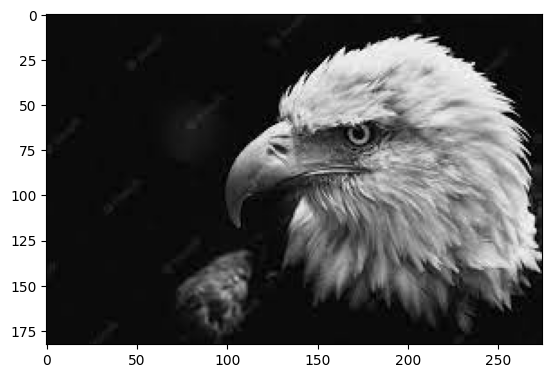

In [110]:
plt.imshow(grayscale_image, cmap='gray')

## Use DNN
To use the model, we need to use the DNN part of OpenCV:

In [111]:
net = cv2.dnn.readNetFromCaffe(proto_file, model_file)
kernel = np.load(hull_pts)

## Preprocess Image
We need to resize and change the colormap of the image:

In [112]:
scaled = grayscale_image.astype("float32") / 255.0
lab_img = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

resized = cv2.resize(lab_img, (224, 224))

L = cv2.split(resized)[0] # split the L channel
L -= 50 # mean subtraction

## Add the cluster centers
Now, add the cluster centers as 1x1 convolutions to the model:

In [113]:
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = kernel.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

We should predict the ab channels from the input L channel:

In [114]:
net.setInput(cv2.dnn.blobFromImage(L))
ab_channel = net.forward()[0, :, :, :].transpose((1, 2, 0))

# resize the predicted 'ab' volume to the same dimensions as our input image
ab_channel = cv2.resize(ab_channel, (grayscale_image.shape[1], grayscale_image.shape[0]))

In [115]:
# Take the L channel from the image
L = cv2.split(lab_img)[0]

colorized = np.concatenate((L[:, :, np.newaxis], ab_channel), axis=2)

In [116]:
# Then convert the image from Lab to BGR
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = np.clip(colorized, 0, 1)

In [121]:

# change the image to 0-255 range and convert it from float32 to int
colorized = (255 * colorized).astype("uint8")

# Let's resize the image
colorized = cv2.resize(colorized,(grayscale_image.shape[1],grayscale_image.shape[0]))

## Result 

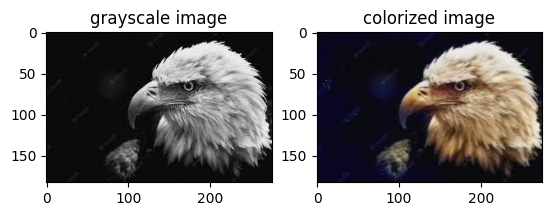

In [122]:
plt.subplot(122); plt.imshow(colorized[...,::-1]);plt.title("colorized image");
plt.subplot(121); plt.imshow(grayscale_image[...,::-1]);plt.title("grayscale image");

## Save

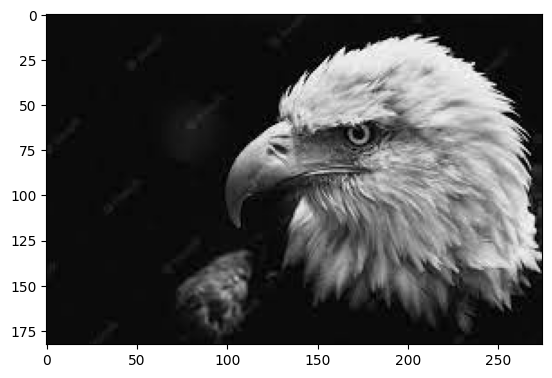

In [136]:
cv2.imwrite(result_path, colorized)